In [89]:
import pandas as pd
import numpy as np
import xarray as xr
from statsmodels.nonparametric.smoothers_lowess import lowess
import plotly.graph_objects as go
from matplotlib import pyplot as plt

# Loading


In [90]:
observed_npp = xr.open_zarr("./products/Hot_observed_npp.zarr")
observed_npp = observed_npp["l12"]
observed_npp.load()

<xarray.DataArray 'l12' (time: 8977, latitude: 1, longitude: 1)> Size: 72kB
array([[[183.4949276 ]],

       [[186.56237688]],

       [[182.15172717]],

       ...,

       [[327.72457179]],

       [[326.50529436]],

       [[334.47255167]]])
Coordinates:
  * latitude   (latitude) float64 8B 22.75
  * longitude  (longitude) int64 8B -158
  * time       (time) datetime64[ns] 72kB 1998-01-01 1998-01-02 ... 2022-07-30
Attributes:
    desc:     L12 multiplied by ZEU (from CMEMS)
    station:  hot
    type:     in situ
    units:    mg m-2 day-1

In [91]:
climato_zoo_obs = xr.open_zarr("./products/Hot_climato_zoo.zarr")
climato_zoo_obs

<xarray.Dataset> Size: 107kB
Dimensions:            (time: 1489, latitude: 1, longitude: 1, layer: 1)
Coordinates:
  * latitude           (latitude) float64 8B 22.75
  * layer              (layer) int64 8B 0
  * longitude          (longitude) int64 8B -158
  * time               (time) datetime64[ns] 12kB 1994-02-20 ... 2022-08-28
Data variables:
    day                (time, latitude, longitude, layer) float64 12kB dask.array<chunksize=(1489, 1, 1, 1), meta=np.ndarray>
    day_lowess_0.05    (time, latitude, longitude, layer) float64 12kB dask.array<chunksize=(1489, 1, 1, 1), meta=np.ndarray>
    day_lowess_0.1     (time, latitude, longitude, layer) float64 12kB dask.array<chunksize=(1489, 1, 1, 1), meta=np.ndarray>
    day_lowess_0.2     (time, latitude, longitude, layer) float64 12kB dask.array<chunksize=(1489, 1, 1, 1), meta=np.ndarray>
    night              (time, latitude, longitude, layer) float64 12kB dask.array<chunksize=(1489, 1, 1, 1), meta=np.ndarray>
    night_lowess_0.05  (time, latitude, longitude, layer) float64 12kB dask.array<chunksize=(1489, 1, 1, 1), meta=np.ndarray>
    night_lowess_0.1   (time, latitude, longitude, layer) float64 12kB dask.array<chunksize=(1489, 1, 1, 1), meta=np.ndarray>
    night_lowess_0.2   (time, latitude, longitude, layer) float64 12kB dask.array<chunksize=(1489, 1, 1, 1), meta=np.ndarray>
Attributes:
    desc:     Aggregated and smoothed observations using lowess filtre.

# Climato


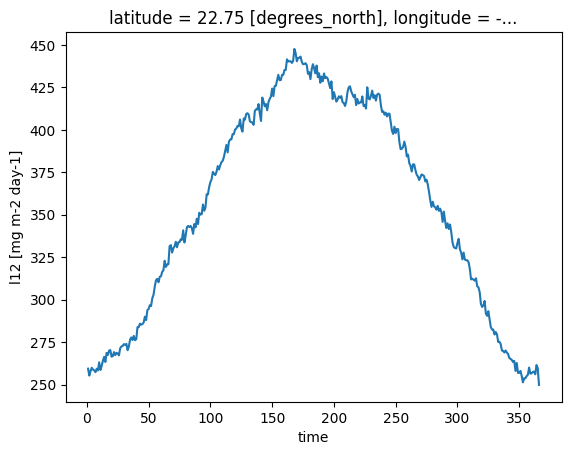

In [92]:
# Convert time to day of year
observed_npp["dayofyear"] = observed_npp["time"].dt.dayofyear

# Group by day of year and calculate the mean
climatology = observed_npp.groupby("dayofyear").mean(dim="time")

climatology.plot()

# Lowess


First we duplicate before and after the time series to make the lowess smoother.


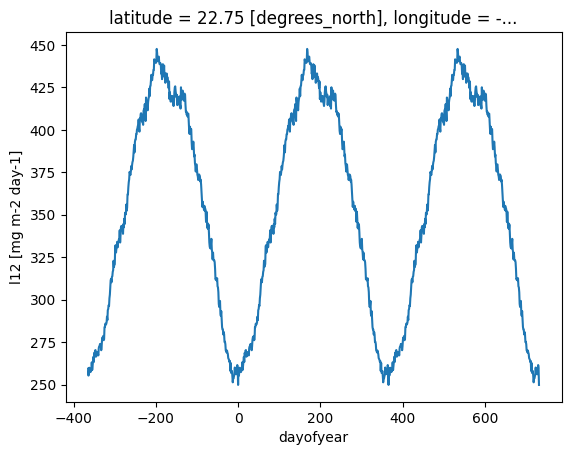

In [93]:
climatology_lower = climatology.assign_coords({"dayofyear": climatology.dayofyear - 366})
climatology_upper = climatology.assign_coords({"dayofyear": climatology.dayofyear + 366})
climatology = xr.concat([climatology_lower, climatology, climatology_upper], dim="dayofyear")
climatology.plot()

Then apply lowess.


In [94]:
climatology_lowess = lowess(
    climatology.values.flatten(),
    climatology["dayofyear"].values.flatten(),
    frac=0.05,
)
climatology_l12_lowess_0_05 = climatology.copy()
climatology_l12_lowess_0_05.data = climatology_lowess[:, 1].reshape(climatology.shape)
climatology_l12_lowess_0_05 = climatology_l12_lowess_0_05.sel(dayofyear=slice(1, 365))
climatology = climatology.sel(dayofyear=slice(1, 365))
climatology = xr.Dataset({"l12": climatology, "l12_lowess_0.05": climatology_l12_lowess_0_05})
climatology

<xarray.Dataset> Size: 9kB
Dimensions:          (latitude: 1, longitude: 1, dayofyear: 365)
Coordinates:
  * latitude         (latitude) float64 8B 22.75
  * longitude        (longitude) int64 8B -158
  * dayofyear        (dayofyear) int64 3kB 1 2 3 4 5 6 ... 361 362 363 364 365
Data variables:
    l12              (dayofyear, latitude, longitude) float64 3kB 259.4 ... 2...
    l12_lowess_0.05  (dayofyear, latitude, longitude) float64 3kB 259.3 ... 2...

In [95]:
import plotly.graph_objects as go

# Convert xarray dataset to pandas DataFrame
climatology_df = climatology.to_dataframe().reset_index()

# Create a figure
fig = go.Figure()

# Add l12 trace
fig.add_trace(go.Scatter(x=climatology_df["dayofyear"], y=climatology_df["l12"], mode="lines", name="L12"))

# Add l12_lowess_0.05 trace
fig.add_trace(
    go.Scatter(x=climatology_df["dayofyear"], y=climatology_df["l12_lowess_0.05"], mode="lines", name="L12 Lowess 0.05")
)

# Update layout
fig.update_layout(title="Climatology L12 and L12 Lowess 0.05", xaxis_title="Day of Year", yaxis_title="Value")

# Show the figure
fig.show()

# Time series duplication


In [96]:
dayofyear_serie = climato_zoo_obs.time.dt.dayofyear.to_dataframe()
tab_1 = dayofyear_serie
tab_2 = climatology.to_dataframe().reset_index()[["dayofyear", "l12", "l12_lowess_0.05"]].set_index("dayofyear")
res = pd.merge(tab_1, tab_2, on="dayofyear", how="left").set_index("dayofyear")
res.index = climato_zoo_obs.to_dataframe().index
res

,,,,l12,l12_lowess_0.05
time,latitude,longitude,layer,,
1994-02-20,22.75,-158,0,296.791563,298.751303
1994-02-27,22.75,-158,0,310.274665,309.710425
1994-03-06,22.75,-158,0,320.747481,320.313807
1994-03-13,22.75,-158,0,334.104992,329.647502
1994-03-20,22.75,-158,0,333.674284,337.928270
...,...,...,...,...,...
2022-07-31,22.75,-158,0,424.991687,419.781888
2022-08-07,22.75,-158,0,418.157723,418.412934
2022-08-14,22.75,-158,0,412.506487,416.813976


In [97]:
climatology = xr.Dataset.from_dataframe(res).sel(layer=0).drop_vars("layer")
climatology

<xarray.Dataset> Size: 36kB
Dimensions:          (time: 1489, latitude: 1, longitude: 1)
Coordinates:
  * time             (time) datetime64[ns] 12kB 1994-02-20 ... 2022-08-28
  * latitude         (latitude) float64 8B 22.75
  * longitude        (longitude) int64 8B -158
Data variables:
    l12              (time, latitude, longitude) float64 12kB 296.8 ... 410.9
    l12_lowess_0.05  (time, latitude, longitude) float64 12kB 298.8 ... 408.5

In [98]:
# Convert xarray dataset to pandas DataFrame
climatology_df = climatology.to_dataframe().reset_index()
observed_npp_df = observed_npp.to_dataframe().reset_index()

# Create a figure
fig = go.Figure()

# Add l12 trace
fig.add_trace(go.Scatter(x=climatology_df["time"], y=climatology_df["l12"], mode="lines", name="L12"))

# Add l12_lowess_0.05 trace
fig.add_trace(
    go.Scatter(x=climatology_df["time"], y=climatology_df["l12_lowess_0.05"], mode="lines", name="L12 Lowess 0.05")
)

# Add observed_npp trace
fig.add_trace(go.Scatter(x=observed_npp_df["time"], y=observed_npp_df["l12"], mode="lines", name="Observed NPP"))

# Update layout
fig.update_layout(title="Climatology and Observed NPP", xaxis_title="Time", yaxis_title="Value")

# Show the figure
fig.show()

# Export


In [113]:
climatology.attrs = {
    "desc": "L12 multiplied by ZEU (from CMEMS).",
    "type": "climatology",
}
climatology.time.attrs = {"axis": "T"}
climatology.latitude.attrs = observed_npp.latitude.attrs
climatology.longitude.attrs = observed_npp.longitude.attrs
climatology.l12.attrs = observed_npp.attrs
climatology["l12_lowess_0.05"].attrs = observed_npp.attrs
climatology["l12_lowess_0.05"].attrs = {
    "desc": "L12 multiplied by ZEU (from CMEMS) smoothed with lowess filter with frac=0.05."
}
climatology

<xarray.Dataset> Size: 36kB
Dimensions:          (time: 1489, latitude: 1, longitude: 1)
Coordinates:
  * time             (time) datetime64[ns] 12kB 1994-02-20 ... 2022-08-28
  * latitude         (latitude) float64 8B 22.75
  * longitude        (longitude) int64 8B -158
Data variables:
    l12              (time, latitude, longitude) float64 12kB 296.8 ... 410.9
    l12_lowess_0.05  (time, latitude, longitude) float64 12kB 298.8 ... 408.5
Attributes:
    desc:     L12 multiplied by ZEU (from CMEMS).
    type:     climatology

In [115]:
climatology.to_zarr("./products/Hot_observed_npp_climato.zarr")